OOOOOOOH boy we made a GPT and had our fun, but now we need to dive into the world of tokenization, head first. Welcome to hell =)
Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

- Why can't LLM spell words? Tokenization.
- Why can't LLM do super simple string processing tasks like reversing a string? Tokenization.
- Why is LLM worse at non-English languages (e.g. Japanese)? Tokenization.
- Why is LLM bad at simple arithmetic? Tokenization.
- Why did GPT-2 have more than necessary trouble coding in Python? Tokenization.
- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? Tokenization.
- What is this weird warning I get about a "trailing whitespace"? Tokenization.
- Why the LLM break if I ask it about "SolidGoldMagikarp"? Tokenization.
- Why should I prefer to use YAML over JSON with LLMs? Tokenization.
- Why is LLM not actually end-to-end language modeling? Tokenization.
- What is the real root of suffering? Tokenization.

Example string:

Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

127 + 677 = 804
1275 + 6773 = 8041

Egg.
I have an Egg.
egg.
EGG.

만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.

for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)

In [238]:
"안녕하세요 👋 (hello in Korean!)"

# How do we feed this text into Python? A string is defined as immutable sequences of Unicode code points.
# Immutable means a state that cannot be modified after it's created. Making a string means there is no going back.
# Any operation in Python that modifies the string actually just makes a new one.
# Unicode codepoints are defined by the Unicode consortium according to the Unicode standard, which is ~150k characters,
# what the characters look like, and what integers represent those characters.
# We can get the integer representation of a character in Python by using ord()

'안녕하세요 👋 (hello in Korean!)'

In [239]:
[ord(x) for x in "안녕하세요 👋 (hello in Korean!)"]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

In [240]:
# Cool, so each charater has an integer defined to it. Why don't we just use those integers as our tokens
# and not even build a tokenizer? 
# 1. Our vocabulary would be super long (~150k)
# 2. The Unicode standard is changing over time

# To solve this, we will turn to encodings. The Unicode consortium defines 3 different encodings: UTF-8,
# UTF-16, and UTF-32. These take unicode text and translate into binary data, or byte streams. We will
# use the UTF-8 encoding (its backwards compatable to ASCI encoding and the 16/32 encodings are more wasteful).

list("안녕하세요 👋 (hello in Korean!)".encode("utf-8")) # gives the raw bytes of the string according to utf-8

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

In [241]:
#list("안".encode("utf-8"))
list("👋".encode("utf-8"))

[240, 159, 145, 139]

In [242]:
# It would be great to directly feed these byte streams into the transformer, but the transformer architecture
# doesn't allow for it. There is some work being done for a tokenization free transformer, but it is in
# the early stages.
# It's also a problem that utf-8 only outputs from 0..255, meaning unique characters could have lots of bytes in the stream
# This is bad because our transformers only have a certian amount of context length, so we will have less information density
# in the same amount of tokens. This is the opposite problem from just using codepoints, where now our vocab is too small.
# We want a large vocabulary size, but we also want to stick with utf-8 encodings.
# To do this, we are going to use the byte pair encoding algorithm =) It generally works as follows:

# Suppose you have the following bytes to be encoded (11 bytes with a vocab of 4)
# aaabdaaabac
# Identify the byte pairs that happen the most often and replace with a byte that is not used in the data (Z)
# Now our bytes turn into
# ZabdZabac (9 bytes with a vocab of 5)
# We can repeat this process, replacing 'ab' with Y
# ZYdZYac (7 bytes with vocab of 6)
# We can now replace "XY" with "X" to get
# XdXac (5 bytes with vocab of 7)
# This is the furthest this data can be compressed, since there are no more pairs that occur more than once.

In [243]:
# Lets get to the implementation. Here is some cool text that we can encode. UTF-8 encodes
# from 0 - 255

text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
text = 'Hello world!'
tokens = text.encode("utf-8") # raw bytes
# The map function matches all of our tokens to a unique integer and returns an iterator. list() turns the map into a list.
tokens = list(map(int, tokens)) # converts to a list of integers in range 0..255 for convenience
print('---')
print(text)
print("length:", len(text))
print('---')
print(tokens)
print('length:', len(tokens))

---
Hello world!
length: 12
---
[72, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 33]
length: 12


In [244]:
# My own code, not Andrej's =)
# Just like the above example, we will find the most common token pair and make a new token numbered 256.

from collections import Counter

# This function finds the most common pair of tokens in a list. 
def find_most_common_pair(tokens):
    pair_counts = Counter()
    # Iterate through all adjacent pairs
    for i in range(len(tokens) - 1):
        pair = (tokens[i], tokens[i + 1])
        pair_counts[pair] += 1
    
    # Find the most common pair
    if pair_counts:
        most_common_pair, _ = pair_counts.most_common(1)[0]
        return most_common_pair
    else:
        return None

top_pair = find_most_common_pair(tokens)
print(top_pair)  # Example usage
chr(101), chr(32)


(72, 101)


('e', ' ')

In [245]:
# In our example, the first most common pair is (101, 32), which is 'e' and ' '. Let's
# take the 'e ' tuple and make a new token.

def merge(ids, pair, idx): # Takes in a list, a pair to swap out, and an idx to replace the pair
    newids = [] # New list to be returned (Can't edit the existing list since list are immutable)
    i = 0 # counter
    while i < len(ids): # while we are not at the last position
        # if we are not in the last position AND we find the pair, replace it =)
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            newids.append(idx) # found teh pair, so add the idx instead
            i += 2 # skip 2 positions over the pair
        else: # Condition where we have not found the pair
            newids.append(ids[i]) # Add current location to new list
            i += 1 # increment to next position
    return newids # return new list with pairs exchanged for idx

# print(merge([5, 6, 6, 7, 9, 1], [6,7], 99))

tokens2 = merge(tokens, top_pair, 256)
print(tokens2)
print("length:", len(tokens2))


[256, 108, 108, 111, 32, 119, 111, 114, 108, 100, 33]
length: 11


In [246]:
# making the training text longer to have more representative token statistics
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = """A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer's perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"""
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255

In [247]:
# counts how many times a given pair occurs in our sequence
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1 # gets the current count for that pair and increments by 1
    return counts

# merges a pair of integers into a new integer. For example, the pair (55,103) could get merged into 256
# We determine the pairs by checking their frequency counts, using get_stats(ids)
def merge(ids, pair, idx): 
    newids = [] 
    i = 0 
    while i < len(ids): 
        # if we are not in the last position AND we find the pair, replace it =)
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            newids.append(idx) 
            i += 2 
        else: 
            newids.append(ids[i]) 
            i += 1 
    return newids 

#------

vocab_size = 276 # desired final vocabulary size
num_merges = vocab_size - 256
ids = list(tokens) # copy so we don't destroy the original list

# merges will be our dictionary of all merges in the vocabulary.
merges = {} # (int, int) -> int
for i in range(num_merges):
    stats = get_stats(ids)
    pair = max(stats, key=stats.get)
    idx = 256 + i
    print(f"merging {pair} into a new token {idx}")
    ids = merge(ids, pair, idx)
    merges[pair] = idx

merging (101, 32) into a new token 256
merging (105, 110) into a new token 257
merging (115, 32) into a new token 258
merging (116, 104) into a new token 259
merging (99, 111) into a new token 260
merging (101, 114) into a new token 261
merging (116, 32) into a new token 262
merging (226, 128) into a new token 263
merging (44, 32) into a new token 264
merging (97, 110) into a new token 265
merging (100, 32) into a new token 266
merging (111, 114) into a new token 267
merging (97, 114) into a new token 268
merging (101, 110) into a new token 269
merging (257, 103) into a new token 270
merging (260, 100) into a new token 271
merging (46, 32) into a new token 272
merging (121, 32) into a new token 273
merging (259, 256) into a new token 274
merging (97, 108) into a new token 275


In [248]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length: 23126
ids length: 18010
compression ratio: 1.28X


Note, the Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

It's worth having a dataset that has similar characters to the dataset used by the LLM (assuming they are different). If you train your tokenizer on a bunch of japanese or python code, japanese and python code will get merged into new tokens, therefore having shorter sequences. This will help your LLM since it has a finite context length by packing more information into a fewer amount of tokens.

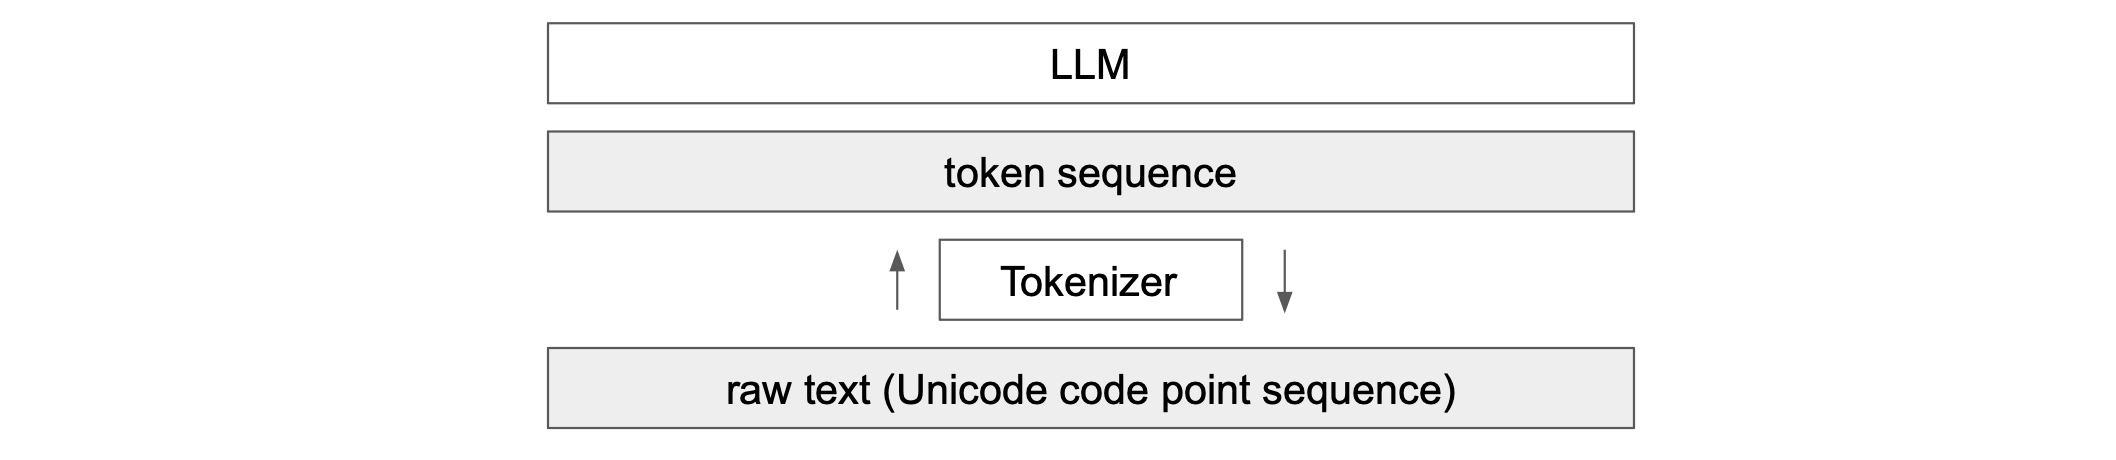

Decoding

Given a sequence of integers in the range [0, vocab_size], what is the text?

In [249]:
# First lets make our vocabulary, then we can decode the integers from that vocabulary. 
# We initialize our vocabulary to first be all the standard bytes 0..255
# Then we have to take into account new bytes we merged. Iterate over the merged bytes and add to vocab

vocab = {idx: bytes([idx]) for idx in range(256)} # Standard bytes 0..255 added to our vocab
for (p0, p1), idx in merges.items(): # For all the merges we made, the new vocab entry is the concatenation of the parent bytes
    vocab[idx] = vocab[p0] + vocab[p1]

def decode(ids):
    # given ids (list of integers), return Python string
    tokens = b"".join(vocab[idx] for idx in ids) # Looks up each id in the vocab dictionary and joins all the bytes into a single byte object
    text = tokens.decode("utf-8", errors="replace") # Decodes the byte object. If we have an invalid byte, replace with the '?' symbol
    return text
        

Encoding

The other way around: Given a string, what are the tokens?

In [250]:
stats

{(65, 32): 7,
 (32, 80): 7,
 (80, 114): 1,
 (114, 111): 57,
 (111, 103): 23,
 (103, 114): 25,
 (114, 97): 40,
 (97, 109): 46,
 (109, 109): 20,
 (109, 261): 10,
 (261, 263): 5,
 (263, 153): 63,
 (153, 258): 28,
 (258, 73): 3,
 (73, 110): 15,
 (110, 116): 18,
 (116, 114): 49,
 (111, 100): 18,
 (100, 117): 6,
 (117, 99): 18,
 (99, 116): 59,
 (116, 105): 131,
 (105, 111): 74,
 (111, 110): 141,
 (110, 32): 76,
 (32, 116): 65,
 (116, 111): 109,
 (111, 32): 135,
 (32, 85): 66,
 (85, 110): 60,
 (110, 105): 71,
 (105, 271): 59,
 (271, 256): 111,
 (256, 77): 2,
 (77, 268): 3,
 (268, 99): 4,
 (99, 104): 86,
 (104, 32): 44,
 (32, 51): 5,
 (51, 264): 2,
 (264, 50): 1,
 (50, 48): 1,
 (48, 49): 7,
 (49, 55): 2,
 (55, 32): 5,
 (32, 194): 2,
 (194, 183): 2,
 (183, 32): 2,
 (32, 67): 8,
 (67, 111): 17,
 (100, 270): 7,
 (270, 32): 107,
 (32, 50): 3,
 (50, 50): 1,
 (50, 32): 14,
 (111, 109): 43,
 (109, 269): 10,
 (269, 116): 36,
 (116, 258): 68,
 (258, 32): 1,
 (32, 239): 1,
 (239, 188): 1,
 (188, 181): 1

In [251]:
merges

{(101, 32): 256,
 (105, 110): 257,
 (115, 32): 258,
 (116, 104): 259,
 (99, 111): 260,
 (101, 114): 261,
 (116, 32): 262,
 (226, 128): 263,
 (44, 32): 264,
 (97, 110): 265,
 (100, 32): 266,
 (111, 114): 267,
 (97, 114): 268,
 (101, 110): 269,
 (257, 103): 270,
 (260, 100): 271,
 (46, 32): 272,
 (121, 32): 273,
 (259, 256): 274,
 (97, 108): 275}

In [252]:
def encode(text):
    # given a string, return list of integers (tokens)
    tokens = list(text.encode("utf-8"))
    while len(tokens) >= 2: # IF we only have a single token or an empty string, stats is empty which causes a problem with min()
        stats = get_stats(tokens)
        # We need to find pairs in the low-> high order. If we go high to low, one of the integers could be a merge itself
        # calling min on a dictionary in python will iterate over the keys (stats)
        # We will take the key from stats, which is a pair of integers, and compare it to our dictionary of merges
        # the get function will search for the pair p. If it finds, it returns it to the min function
        # If not, turns it to inf, making that pair ineligible
        pair = min(stats, key=lambda p: merges.get(p, float("inf")))
        if pair not in merges:
            break # nothing else can be merged
        # then we take the pair and merge it
        idx = merges[pair]
        tokens = merge(tokens, pair, idx)
    return tokens

print(encode("hello world!"))
    

[104, 101, 108, 108, 111, 32, 119, 267, 108, 100, 33]


In [253]:
print(decode(encode("hello world")))

hello world


In [254]:
text2 = decode(encode(text))
print(text2 == text)

True


In [255]:
valtext = "The Tokenizer is a necessary and pervasive component of Large Language Models (LLMs), where it translates between strings and tokens (text chunks). Tokenizers are a completely separate stage of the LLM pipeline: they have their own training sets, training algorithms (Byte Pair Encoding), and after training implement two fundamental functions: encode() from strings to tokens, and decode() back from tokens to strings. In this lecture we build from scratch the Tokenizer used in the GPT series from OpenAI. In the process, we will see that a lot of weird behaviors and problems of LLMs actually trace back to tokenization. We'll go through a number of these issues, discuss why tokenization is at fault, and why someone out there ideally finds a way to delete this stage entirely."
valtext2 = decode(encode(valtext))
print(valtext == valtext2)

True


In [256]:
# This is a way to make sure we are not merging across words, punctuation, numbers

import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

# Searches the input string for all occurances that matche the regex pattern and returns as a list of strings
print(re.findall(gpt2pat, "Hello've world123 how's are you!?")) 

['Hello', "'ve", ' world', '123', ' how', "'s", ' are', ' you', '!?']


In [257]:
# Lets look at how the GPT models encode. OpenAI uses the tiktoken library.

import tiktoken

#GPT-2 (does not merge spaces)
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("     hello world!!!"))

# GPT-4 (merges spaces)
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("     hello world!!!"))


[220, 220, 220, 220, 23748, 995, 10185]
[257, 24748, 1917, 12340]


In [258]:
# Reference the GPT-2 encoder.py Download the vocab.bpe and encoder.json files.
# https://github.com/openai/gpt-2/blob/master/src/encoder.py

!powershell -command "Invoke-WebRequest -Uri 'https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe' -OutFile 'vocab.bpe'"
!powershell -command "Invoke-WebRequest -Uri 'https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json' -OutFile 'encoder.json'"

In [259]:
import os, json

with open('encoder.json', 'r') as f:
    encoder = json.load(f) # <--- ~equivalent to our "vocab"

with open('vocab.bpe', 'r', encoding="utf-8") as f:
    bpe_data = f.read()
bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
# ^---- ~equivalent to our "merges"

Special tokens

In [260]:
len(encoder) # 256 raw byte tokens. 50,000 merges. 1 special token.

50257

In [261]:
# delimits documents in a string of text. It's a signal to the model that one document has ended
# and another has started.
# This didn't come from a series of merges, but rather hardcoded in the tiktoken rust library with
# special rules.
encoder['<|endoftext|>'] 

50256

In [262]:
# It's also possible to add your own tokens using the tiktoken library. You can create a dictionary of keys (string)
# and values (token). Just make sure that you update your transform to account for the new tokens. You need
# to make sure that the embedding matrix has a vector for each of your new tokens, and that the final
# layer has its projection extended by your number of new tokens. Small amount of surgery, but it works =)

Exercise: Build your own GPT-4 Tokenizer!

In [263]:
#------------Useful functions---------------------

def merge(ids, pair, idx): 
    newids = [] 
    i = 0 
    while i < len(ids): 
        # if we are not in the last position AND we find the pair, replace it =)
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            newids.append(idx) 
            i += 2 
        else: 
            newids.append(ids[i]) 
            i += 1 
    return newids 

def get_stats(ids, counts=None):
    counts = {} if counts is None else counts
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1 # gets the current count for that pair and increments by 1
    return counts


# --------------Tokenizer class-----------------

class BasicTokenizer:

    def __init__(self):
        self.merges = {}
        self.vocab = {}

    def train(self, text, vocab_size, verbose=False):
        assert vocab_size >= 256
        num_merges = vocab_size - 256

        text_bytes = text.encode("utf-8") # raw bytes
        tokens = list(text_bytes) # convert to a list of integers in range 0..255

        # iteratively merge the most common pairs to create new tokens
        merges = {} # (int, int) -> int
        vocab = {idx: bytes([idx]) for idx in range(256)} # int -> bytes
        for i in range(num_merges):
            stats = get_stats(tokens)
            # Check if stats is empty
            if not stats:
                print("No more pairs to merge.")
                break  # Exit the loop if there are no pairs to merge
            pair = max(stats, key=stats.get)
            idx = 256 + i
            tokens = merge(tokens, pair, idx)
            merges[pair] = idx
            vocab[idx] = vocab[pair[0]] + vocab[pair[1]]
            if verbose:
                print(f"merge {i+1}/{num_merges}: {pair} -> {idx} ({vocab[idx]}) had {stats[pair]} occurrences")
        self.merges = merges
        self.vocab = vocab

    def encode(self, text):
        # given a string, return list of integers (tokens)
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2: 
            stats = get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break # nothing else can be merged
            idx = self.merges[pair]
            tokens = merge(tokens, pair, idx)
        return tokens

    def decode(self, ids):
        text_bytes = b"".join(self.vocab[idx] for idx in ids) 
        text = text_bytes.decode("utf-8", errors="replace")
        return text

In [264]:
# Open the file and read its contents
with open('taylorswift.txt', 'r', encoding='utf-8') as file:
    text = file.read()  # Read the entire content of the file

# Now train the tokenizer with the content of the file
tokenizer = BasicTokenizer()
tokenizer.train(text, 1000, verbose=True)

merge 1/744: (101, 32) -> 256 (b'e ') had 2981 occurrences
merge 2/744: (44, 32) -> 257 (b', ') had 2961 occurrences
merge 3/744: (100, 32) -> 258 (b'd ') had 2617 occurrences
merge 4/744: (46, 32) -> 259 (b'. ') had 2560 occurrences
merge 5/744: (114, 32) -> 260 (b'r ') had 2428 occurrences
merge 6/744: (50, 48) -> 261 (b'20') had 2365 occurrences
merge 7/744: (115, 32) -> 262 (b's ') had 2053 occurrences
merge 8/744: (105, 110) -> 263 (b'in') had 2006 occurrences
merge 9/744: (111, 110) -> 264 (b'on') had 1815 occurrences
merge 10/744: (114, 105) -> 265 (b'ri') had 1805 occurrences
merge 11/744: (116, 32) -> 266 (b't ') had 1802 occurrences
merge 12/744: (116, 104) -> 267 (b'th') had 1737 occurrences
merge 13/744: (101, 258) -> 268 (b'ed ') had 1736 occurrences
merge 14/744: (257, 261) -> 269 (b', 20') had 1705 occurrences
merge 15/744: (97, 110) -> 270 (b'an') had 1487 occurrences
merge 16/744: (97, 114) -> 271 (b'ar') had 1360 occurrences
merge 17/744: (101, 260) -> 272 (b'er ') ha

In [265]:
# OMGGGGGGG it works =))))

test = 'woohoo I think this is working %wa]     [fe4td 안녕하세요 👋 (hello in Korean!)'
test2 = tokenizer.encode(test)
test3 = tokenizer.decode(test2)
print(test == test3)

True


In [267]:
# Great! Now lets create the GPT4 split version. What will happen now is that we take our training text and split it up
# into a list of strings that follows the GPT4_SPLIT_PATTERN rules. This does things like separate letters, numbers, and 
# punctuation into separate strings, clumps together whitespace, separates line breaks, etc. To motivate the rules,
# imagine we had a token that was ' Dog', but we also had ' Dog.', ' Dog!', and ' Dog?'. This results in sub-optimal
# allocation of limited vocabulary slots. To prevent this, we use the GPT4 split rules.

import regex as re
GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""

class RegexTokenizer(BasicTokenizer): #BasicTokenizer isn't an input, but a parent class. RegexTokenizer inherits 
                                    # all attributes and methods from BasicTokenizer

    def __init__(self):
        super().__init__() # This initializes a RegexTokenizer object with inherited methods and attributes from BasicTokenizer
        self.pattern = GPT4_SPLIT_PATTERN
        self.compiled_pattern = re.compile(self.pattern)

    def train(self, text, vocab_size, verbose=False):
        assert vocab_size >= 256
        num_merges = vocab_size - 256
        
        # Split the text into chunks using regex object
        # List of strings
        text_chunks = re.findall(self.compiled_pattern, text)

        # Create your tokens from the text_chunks
        tokens = [list(ch.encode("utf-8")) for ch in text_chunks]

        # iteratively merge the most common pairs to create new tokens
        merges = {} # (int, int) -> int
        vocab = {idx: bytes([idx]) for idx in range(256)} # int -> bytes
        for i in range(num_merges):
            # count the number of times every consecutive pair appears
            stats = {}
            for chunk_ids in tokens:
                # passing in stats will update it in place, adding up counts
                get_stats(chunk_ids, stats)
            pair = max(stats, key=stats.get)
            idx = 256 + i
            tokens = [merge(chunk_ids, pair, idx) for chunk_ids in tokens]
            merges[pair] = idx
            vocab[idx] = vocab[pair[0]] + vocab[pair[1]]
            if verbose:
                print(f"merge {i+1}/{num_merges}: {pair} -> {idx} ({vocab[idx]}) had {stats[pair]} occurrences")
        self.merges = merges
        self.vocab = vocab

In [268]:
# Open the file and read its contents
with open('taylorswift.txt', 'r', encoding='utf-8') as file:
    text = file.read()  # Read the entire content of the file

# Now train the tokenizer with the content of the file
regexTokenizer = RegexTokenizer()
regexTokenizer.train(text, 1000, verbose=True)

merge 1/744: (101, 114) -> 256 (b'er') had 2359 occurrences
merge 2/744: (50, 48) -> 257 (b'20') had 2187 occurrences
merge 3/744: (111, 114) -> 258 (b'or') had 2076 occurrences
merge 4/744: (105, 110) -> 259 (b'in') had 2006 occurrences
merge 5/744: (101, 100) -> 260 (b'ed') had 1876 occurrences
merge 6/744: (32, 116) -> 261 (b' t') had 1824 occurrences
merge 7/744: (111, 110) -> 262 (b'on') had 1815 occurrences
merge 8/744: (104, 101) -> 263 (b'he') had 1772 occurrences
merge 9/744: (32, 83) -> 264 (b' S') had 1633 occurrences
merge 10/744: (97, 114) -> 265 (b'ar') had 1519 occurrences
merge 11/744: (97, 110) -> 266 (b'an') had 1487 occurrences
merge 12/744: (32, 65) -> 267 (b' A') had 1335 occurrences
merge 13/744: (261, 263) -> 268 (b' the') had 1169 occurrences
merge 14/744: (97, 108) -> 269 (b'al') had 1164 occurrences
merge 15/744: (114, 105) -> 270 (b'ri') had 1156 occurrences
merge 16/744: (118, 260) -> 271 (b'ved') had 1104 occurrences
merge 17/744: (115, 116) -> 272 (b'st') 

In [269]:
# Now that we are using the GPT4 split, there are no tokens that go across categories (ie. numbers, letters, punctuation, etc)

regexTokenizer.vocab

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [275]:
# PROOF THAT MY IMPLEMENTATION IS THE SAME AS THE GPT4 IMPLEMENTATION WOOOOOOOOOOOOOOOO
# The only difference is we have differnet merges{}, which just comes from having different training data
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # this is the GPT-4 tokenizer
ids = enc.encode("hello world!!!? (안녕하세요!) lol123 😉")
text = enc.decode(ids) # get the same text back
myids = regexTokenizer.encode("hello world!!!? (안녕하세요!) lol123 😉")
mytext = regexTokenizer.decode(myids)
print(text == mytext)
print(ids)
print(text)
print('-----------------')
print(myids)
print(mytext)

True
[15339, 1917, 12340, 30, 320, 31495, 230, 75265, 243, 92245, 16715, 28509, 4513, 57037]
hello world!!!? (안녕하세요!) lol123 😉
-----------------
[263, 301, 111, 340, 606, 33, 33, 33, 63, 293, 236, 149, 136, 235, 133, 149, 237, 149, 152, 236, 132, 184, 236, 154, 148, 33, 41, 442, 412, 49, 484, 32, 240, 159, 152, 137]
hello world!!!? (안녕하세요!) lol123 😉


### sentencepiece

Commonly used because (unlike tiktoken) it can efficiently both train and inference BPE tokenizers. It is used in both Llama and Mistral series.

[sentencepiece on Github link](https://github.com/google/sentencepiece).

**The big difference**: sentencepiece runs BPE on the Unicode code points directly! It then has an option `character_coverage` for what to do with very very rare codepoints that appear very few times, and it either maps them onto an UNK token, or if `byte_fallback` is turned on, it encodes them with utf-8 and then encodes the raw bytes instead.

TLDR:

- tiktoken encodes to utf-8 and then BPEs bytes
- sentencepiece BPEs the code points and optionally falls back to utf-8 bytes for rare code points (rarity is determined by character_coverage hyperparameter), which then get translated to byte tokens.


In [277]:
# pip install sentencepiece on your command prompt. If using anaconda, use the anaconda 
# prompt (should see 'base' at the beginning)
import sentencepiece as spm

In [278]:
# write a toy.txt file with some random text
with open("toy.txt", "w", encoding="utf-8") as f:
  f.write("SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.")

Docs for sentencepiece options:

- [markdown](https://github.com/google/sentencepiece/blob/master/doc/options.md)
- [protobuf](https://github.com/google/sentencepiece/blob/master/src/sentencepiece_model.proto#L193)

In [279]:
# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="toy.txt",
  input_format="text",
  # output spec
  model_prefix="tok400", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=400,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995, # If the character only occurs 1 in a million, for example, 
  # it wouldn't be added
  byte_fallback=True, # Loads the default 256 byte tokens
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens. These come first in the vocab
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1, # turned off
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)


In [280]:
sp = spm.SentencePieceProcessor()
sp.load('tok400.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['<0x00>', 3],
 ['<0x01>', 4],
 ['<0x02>', 5],
 ['<0x03>', 6],
 ['<0x04>', 7],
 ['<0x05>', 8],
 ['<0x06>', 9],
 ['<0x07>', 10],
 ['<0x08>', 11],
 ['<0x09>', 12],
 ['<0x0A>', 13],
 ['<0x0B>', 14],
 ['<0x0C>', 15],
 ['<0x0D>', 16],
 ['<0x0E>', 17],
 ['<0x0F>', 18],
 ['<0x10>', 19],
 ['<0x11>', 20],
 ['<0x12>', 21],
 ['<0x13>', 22],
 ['<0x14>', 23],
 ['<0x15>', 24],
 ['<0x16>', 25],
 ['<0x17>', 26],
 ['<0x18>', 27],
 ['<0x19>', 28],
 ['<0x1A>', 29],
 ['<0x1B>', 30],
 ['<0x1C>', 31],
 ['<0x1D>', 32],
 ['<0x1E>', 33],
 ['<0x1F>', 34],
 ['<0x20>', 35],
 ['<0x21>', 36],
 ['<0x22>', 37],
 ['<0x23>', 38],
 ['<0x24>', 39],
 ['<0x25>', 40],
 ['<0x26>', 41],
 ['<0x27>', 42],
 ['<0x28>', 43],
 ['<0x29>', 44],
 ['<0x2A>', 45],
 ['<0x2B>', 46],
 ['<0x2C>', 47],
 ['<0x2D>', 48],
 ['<0x2E>', 49],
 ['<0x2F>', 50],
 ['<0x30>', 51],
 ['<0x31>', 52],
 ['<0x32>', 53],
 ['<0x33>', 54],
 ['<0x34>', 55],
 ['<0x35>', 56],
 ['<0x36>', 57],
 ['<0x37>', 58],
 ['<0x38>', 5

In [281]:
ids = sp.encode("hello 안녕하세요")
print(ids)

[362, 378, 361, 372, 358, 362, 239, 152, 139, 238, 136, 152, 240, 152, 155, 239, 135, 187, 239, 157, 151]


In [282]:
# Notice how the korean characters are represented as bytes for tokens. This is because korean characters were
# not encountered during training, so there isn't a predefined token for them. To handle them,
# sentencepiece encodes the korean characters using utf-8, then uses those bytes to represent the words
# This works because byte_fallback is turned on, meaning the vocab list contains the standard 256 byte tokens.
# If byte_fallback is False, we don't have the utf-8 byte tokens in our vocab, so the korean characters
# are unknown. They get labeled as a 0, the special token <unk>

# Also notice the extra space that comes before hello. Where did that come from?
# It comes when add_dummy_prefix is True. It does this so that 'world' in 'world'
# and 'hello world' are treated the same.
print([sp.id_to_piece(idx) for idx in ids])

['▁', 'h', 'e', 'l', 'lo', '▁', '<0xEC>', '<0x95>', '<0x88>', '<0xEB>', '<0x85>', '<0x95>', '<0xED>', '<0x95>', '<0x98>', '<0xEC>', '<0x84>', '<0xB8>', '<0xEC>', '<0x9A>', '<0x94>']


As a reminder of why we care about vocab_size, recall the GPT model we made (bigramv2.py). vocab size only comes
up at the beginning in the embedding table, and at the end in the lm_head (which gets fed into logits). For each 
vocab entry we add, the embedding table gets another row added, meaning all matrix multiplication gets longer. Also,
at the end with logits, there are now more possible options the model could output. If we had 1 million tokens, the 
model now needs to generate probabilities for 1 million different tokens! This is when we start to worry about
undertraining. If our dataset only has a few examples of certain tokens, its relative probability will be much lower
only because there is so much of everything else. They don't come up as often and don't participate in the
forward/backward pass.

On the other hand, a large vocab means more and more tokens are being considered within our finite context
window, which is great. But, if we are squishing too much information into a token, the model won't have
enough time in its forward and backwards pass to appropriatley process that information.

As of today (Oct 13 2024), top of the line model normally have vocab_sizes in the high 10 thousands, maybe
even 100,000.